# Exercise 1: Introduction to pyiron

## Imports and and working with projects

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project

In [3]:
pr = Project("demo")

# To delete all jobs and start from scratch, uncomment the next line
#pr.remove_jobs(recursive=True)

## Creating and manipulating structures

In [4]:
# atomistic structures
Al_struct = pr.create_ase_bulk("Al", cubic=True).repeat([2, 2, 4])
Al_struct.plot3d()

_ColormakerRegistry()

NGLWidget()

In [5]:
Al_struct[36] = "Cu"
Al_struct.plot3d(particle_size=3)

NGLWidget()

In [6]:
del Al_struct[17]
Al_struct.plot3d(particle_size=3)

NGLWidget()

### Creating bulk water consisting of several water molecules

In [7]:
cell = np.eye(3) * 10
r_O = [0, 0, 0]
r_H1 = [0.0, 0.7, 0.7]
r_H2 = [0.0, 0.7, -0.7]
water_molecule = pr.create_atoms("H2O", positions=[r_H1, r_H2, r_O], cell=cell)
water_molecule.center()
water_molecule.set_cell(water_molecule.cell * water_molecule.get_density() ** (1/3), scale_atoms=False)
water_molecule.get_density()
water_box = water_molecule.repeat(3)
water_box.center_coordinates_in_unit_cell()
water_box.plot3d(spacefill=False)

NGLWidget()

### Creating an Al supercell with interstitial H

#### Create Al sublattice

In [8]:
Al_struct = pr.create_ase_bulk("Al", cubic=True)

#### Create H interstitial sublattice

In [9]:
H_int = Al_struct.copy()
H_int[:] = "H"
H_int.scaled_positions += 0.5

#### Create a 2x2x4 supercell for both lattices

In [10]:
Al_struct.set_repeat([2, 2, 4])
H_int.set_repeat([2, 2, 4])

#### Occupy the H sublattice randomly with 10 H atoms 

In [11]:
rand_int = np.arange(0, len(H_int))
np.random.shuffle(rand_int)
H_int = H_int[rand_int[:10]]

#### Combine Al and H sublattice in same supercell

In [12]:
AlH_struct = Al_struct + H_int
AlH_struct.plot3d(particle_size=3)

NGLWidget()

## Perform a MD simulation of the AlH supercell using LAMMPS

### Setup the Lammps calculation

In [13]:
job_lammps = pr.create_job(job_type=pr.job_type.Lammps, job_name= "AlH_lammps")
job_lammps.structure = AlH_struct
print(job_lammps.list_potentials())
job_lammps.potential =  'Al_H_Ni_Angelo_eam'
job_lammps.calc_md(temperature=600, n_ionic_steps=10000)

['Al_H_Ni_Angelo_eam', '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1', '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1', 'EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_418978237058_005']


In [14]:
job_lammps.run()

2020-04-17 12:14:21,559 - pyiron_log - WARNING - The job AlH_lammps is being loaded instead of running. To re-run use the argument 'run_again=True'


### Animate MD trajectories

In [15]:
job_lammps.animate_structure(particle_size=1)

NGLWidget(max_frame=100)

### Analyze trajectories in more detail

In [16]:
H_indices = AlH_struct.select_index("H")
Al_indices = AlH_struct.select_index("Al")
H_indices

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

#### Plot Al trajectories in grey, H ones in red

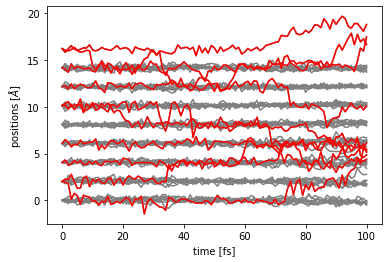

In [17]:
plt.plot(job_lammps.output.unwrapped_positions[:, :, 2], color="grey")
plt.plot(job_lammps.output.unwrapped_positions[:, H_indices, 2], color="red")
plt.xlabel("time [fs]")
plt.ylabel("positions [$\AA$]");

### Visualize the last MD configuration

In [18]:
md_struct = job_lammps.get_structure(iteration_step=-1)
md_struct.plot3d(particle_size=2)

NGLWidget()

### Take the last configuration and perform structure relaxation (including cell relaxation - pressure=0)

In [19]:
job_lammps_minimize = pr.create_job(pr.job_type.Lammps, "AlH_minimize")
job_lammps_minimize.structure = md_struct

In [20]:
job_lammps_minimize.potential = job_lammps.potential.copy() # this looks not so nice, could we take a copy of job_lammps?

In [21]:
job_lammps_minimize.calc_minimize(pressure=0)
job_lammps_minimize.run()

2020-04-17 12:14:25,848 - pyiron_log - WARNING - The job AlH_minimize is being loaded instead of running. To re-run use the argument 'run_again=True'


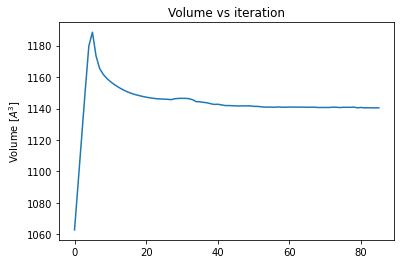

In [22]:
plt.plot(job_lammps_minimize.output.volume)
plt.title('Volume vs iteration')
plt.ylabel('Volume [$A^3$]');

In [23]:
job_lammps_minimize.animate_structure(particle_size=1)

NGLWidget(max_frame=85)

In [24]:
job_lammps_minimize.get_structure(-1).plot3d(particle_size=2)

NGLWidget()

## Analysis

### Plot Al-Al and H-H pair correlation function of the last MD structure

This is done using the `get_neighbors()` function

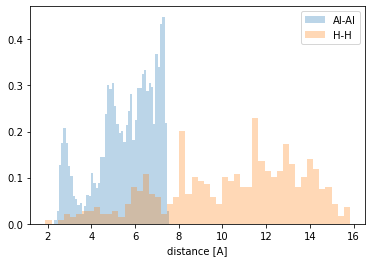

In [25]:
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_md = md_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.xlabel('distance [A]')
plt.legend();

### Plot Al-Al and H-H pair correlation function after structure and cell relaxation 

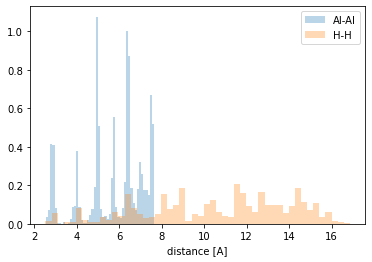

In [26]:
min_struct = job_lammps_minimize.get_structure(-1)
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al")
neighbors_min = min_struct[H_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="H-H")
plt.xlabel('distance [A]')
plt.legend();

### Compare Al-Al pair correlation before and after relaxation

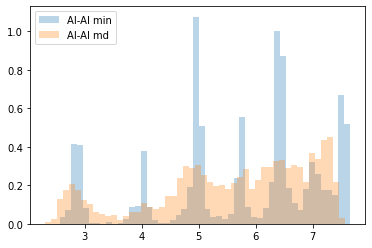

In [27]:
neighbors_min = min_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_min.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al min")
neighbors_md = md_struct[Al_indices].get_neighbors(num_neighbors=100)
plt.hist(neighbors_md.distances.flatten(), bins=50, alpha=0.3, density=True, label="Al-Al md")
plt.legend();

### Utility functions

In [28]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1491,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/,2020-04-17 11:50:02.094918,2020-04-17 11:50:06.136120,4.0,pyiron@cmdell17#1,Lammps,0.1,None,NaN
1,1492,finished,Al64H10,AlH_minimize,/AlH_minimize,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/,2020-04-17 11:50:08.942298,2020-04-17 11:50:12.974839,4.0,pyiron@cmdell17#1,Lammps,0.1,None,NaN
2,1493,finished,Al4,Al_a_3_9,/Al_a_3_9,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/Al_murnaghan_manual/,2020-04-17 11:50:22.689141,2020-04-17 11:50:23.516998,0.0,pyiron@cmdell17#1,Lammps,0.1,None,NaN
3,1494,finished,Al4,Al_a_3_92,/Al_a_3_92,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/Al_murnaghan_manual/,2020-04-17 11:50:24.083709,2020-04-17 11:50:24.818895,0.0,pyiron@cmdell17#1,Lammps,0.1,None,NaN
4,1495,finished,Al4,Al_a_3_94,/Al_a_3_94,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/Al_murnaghan_manual/,2020-04-17 11:50:25.363148,2020-04-17 11:50:26.061825,0.0,pyiron@cmdell17#1,Lammps,0.1,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1621,finished,Al4,strain_1_02,/strain_1_02,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2004__Zhou_X_W__Al__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:55:46.292930,2020-04-17 11:55:47.158251,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1614.0
131,1622,finished,Al4,strain_1_04,/strain_1_04,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2004__Zhou_X_W__Al__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:55:48.465062,2020-04-17 11:55:49.263164,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1614.0
132,1623,finished,Al4,strain_1_06,/strain_1_06,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2004__Zhou_X_W__Al__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:55:50.518689,2020-04-17 11:55:51.442598,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1614.0
133,1624,finished,Al4,strain_1_08,/strain_1_08,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2004__Zhou_X_W__Al__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:55:52.782326,2020-04-17 11:55:53.660888,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1614.0


In [29]:
job_md_reloaded = pr.load("AlH_lammps")

In [30]:
job_min_reloaded = pr.load("AlH_minimize")

In [31]:
type(job_min_reloaded)

pyiron.lammps.lammps.Lammps

In [32]:
pr

{'groups': ['Al_murnaghan_manual', 'band_structure', 'murnaghan_Al_dft', 'murnaghan_automatic', 'potential_scan', 'sphinx_demo'], 'nodes': ['AlH_lammps', 'AlH_minimize']}

In [33]:
pr["AlH_lammps"]

{'groups': ['input', 'output'], 'nodes': ['NAME', 'TYPE', 'VERSION', 'server', 'status']}

In [34]:
pr["AlH_lammps/input"]

{'groups': ['control_inp', 'generic', 'potential', 'potential_inp', 'structure'], 'nodes': ['generic_dict', 'interactive']}

In [35]:
pr["AlH_lammps/output/generic/forces"].shape,  pr["AlH_lammps/output/generic/energy_tot"].shape

((101, 74, 3), (101,))

## Energy volume curves for Al

### Manual setup and analysys

In [36]:
pr = Project("demo/Al_murnaghan_manual")

In [37]:
a_list = np.linspace(3.9, 4.1, 11)
for a in a_list:
    job_name = "Al_a_{}".format(a).replace(".", "_")
    job = pr.create_job(pr.job_type.Lammps, job_name)
    job.structure = pr.create_ase_bulk("Al", a=a, cubic=True)
    job.potential = 'Al_H_Ni_Angelo_eam'
    job.calc_minimize()
    job.run()

2020-04-17 12:14:37,797 - pyiron_log - WARNING - The job Al_a_3_9 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:40,296 - pyiron_log - WARNING - The job Al_a_3_92 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:44,419 - pyiron_log - WARNING - The job Al_a_3_94 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:47,396 - pyiron_log - WARNING - The job Al_a_3_96 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:50,397 - pyiron_log - WARNING - The job Al_a_3_98 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:53,179 - pyiron_log - WARNING - The job Al_a_4_0 is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:14:55,681 - pyiron_log - WARNING - The job Al_a_4_02 is being loaded instead of running. To re-run use the

In [38]:
pr.job_table();

### Analysis: Loading vs inspecting jobs

The data from these calculations are retreived either by loading each of these jobs or by inspecting them (from their hdf5 files).

In [39]:
job_loaded = pr.load("Al_a_3_9")
struct = job_loaded.get_structure()
job_loaded.output.energy_tot, job_loaded["output/generic/energy_tot"], type(job_loaded)

(array([-13.21258266, -13.21258266]),
 array([-13.21258266, -13.21258266]),
 pyiron.lammps.lammps.Lammps)

In [40]:
job_inspect = pr.inspect("Al_a_3_9")
job_loaded["output/generic/energy_tot"], type(job_inspect)

(array([-13.21258266, -13.21258266]), pyiron.base.job.path.JobPath)

So why use the inspect mode if recreating the object gives access to all it's pyiron functions? The inspect mode is actually much faster if you only want to access certain values without recreating the entire job object.

CPU times: user 297 ms, sys: 31.2 ms, total: 328 ms
Wall time: 392 ms


pyiron.base.job.path.JobPath

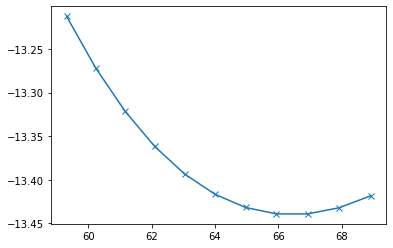

In [41]:
%%time
convert_to_object = False # True to load the job
vol_list = list()
energy_list = list()
# Set recursive=False to only go over the higher levels and not return jobs from subprojects
for job in pr.iter_jobs(convert_to_object=convert_to_object, recursive=False):
    if job.status == "finished":
        vol_list.append(job["output/generic/volume"][-1])
        energy_list.append(job["output/generic/energy_tot"][-1])
plt.plot(vol_list, energy_list, "-x")
type(job)

## Energy-Volume curves using predefined modules

We will now use the predefined Murnaghan module to compute equilibrium T=0K properties 

In [42]:
pr = Project("demo/murnaghan_automatic")

### Setup of the Murnaghan job and a reference calculation for the parameters

In [43]:
# Initialize the Murnaghan "job"
murn = pr.create_job(pr.job_type.Murnaghan, "murn_test")
# Create a reference job which contains all simulation parameters
job_ref = pr.create_job(pr.job_type.Lammps, "Al_ref")
job_ref.structure = pr.create_ase_bulk("Al", cubic=True)
job_ref.potential = 'Al_H_Ni_Angelo_eam'
job_ref.calc_minimize()
murn.ref_job = job_ref

The Murnaghan job creates individual LAMMPS calculations with a strained unitcell

In [44]:
murn.run()

2020-04-17 12:15:13,923 - pyiron_log - WARNING - The job murn_test is being loaded instead of running. To re-run use the argument 'run_again=True'


In [45]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1504,finished,Al4,murn_test,/murn_test,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/,2020-04-17 11:50:38.699814,2020-04-17 11:51:02.556537,23.0,pyiron@cmdell17#1#11/11,Murnaghan,0.3.0,None,NaN
1,1505,finished,Al4,strain_0_9,/strain_0_9,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:40.062027,2020-04-17 11:50:40.850802,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
2,1506,finished,Al4,strain_0_92,/strain_0_92,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:42.125409,2020-04-17 11:50:42.885062,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
3,1507,finished,Al4,strain_0_94,/strain_0_94,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:44.289825,2020-04-17 11:50:45.176686,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
4,1508,finished,Al4,strain_0_96,/strain_0_96,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:46.688354,2020-04-17 11:50:47.598676,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
5,1509,finished,Al4,strain_0_98,/strain_0_98,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:48.755947,2020-04-17 11:50:49.634160,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
6,1510,finished,Al4,strain_1_0,/strain_1_0,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:50.913039,2020-04-17 11:50:51.648389,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
7,1511,finished,Al4,strain_1_02,/strain_1_02,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:53.035373,2020-04-17 11:50:53.854134,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
8,1512,finished,Al4,strain_1_04,/strain_1_04,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:55.112082,2020-04-17 11:50:55.868434,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0
9,1513,finished,Al4,strain_1_06,/strain_1_06,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/murnaghan_automatic/murn_test_hdf5/,2020-04-17 11:50:57.118693,2020-04-17 11:50:57.872790,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1504.0


### Plotting and inspecting the murnaghan output

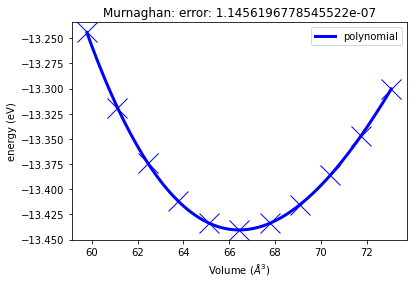

In [46]:
murn.plot()

In [47]:
murn["output"]

{'groups': ['structure'], 'nodes': ['energy', 'equilibrium_b_prime', 'equilibrium_bulk_modulus', 'equilibrium_energy', 'equilibrium_volume', 'error', 'id', 'volume']}

In [48]:
murn["output/equilibrium_volume"] ** (1/3), murn["output/equilibrium_bulk_modulus"]

(4.049953713580603, 81.04044546401586)

In [49]:
murn.fit_dict

{'poly_fit': array([-9.56553731e-05,  2.28697903e-02, -1.77209828e+00,  3.13985247e+01]),
 'fit_type': 'polynomial',
 'fit_order': 3,
 'volume_eq': 66.42784738704798,
 'energy_eq': -13.440396614411778,
 'bulkmodul_eq': 81.04044546401586,
 'b_prime_eq': 4.006907327547416,
 'least_square_error': 1.1456196778545522e-07}

In [50]:
job_child = murn[0]

## Energy-volume curves for a variety of Al potentials

Since an E-V curve can be calculated quite easily, we can now do this for a range of available Al potentials (keep in mind that some of these potentials might fail)

In [51]:
pr = Project("demo/potential_scan")
###pr.remove_jobs()

### Looping over available potenitals

In [52]:
#Chosing only a few potentials since there are lots of Al potentials

potential_list = job_child.list_potentials()[0:10]

In [53]:
for pot in potential_list:
    pot_str = pot.replace("-", "_")
    # open a subproject within a project
    with pr.open(pot_str) as pr_sub:
        # no need for unique job name if in different subprojects 
        job_name = "murn_Al"
        # Use the subproject to create the jobs
        murn = pr_sub.create_job(pr.job_type.Murnaghan, job_name)
        job_ref = pr_sub.create_job(pr.job_type.Lammps, "Al_ref")
        job_ref.structure = pr.create_ase_bulk("Al", cubic=True)
        job_ref.potential = pot
        job_ref.calc_minimize()
        murn.ref_job = job_ref
        try:
            murn.run()
        except RuntimeError:
            pass

2020-04-17 12:15:20,285 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:21,584 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:22,804 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:23,132 - pyiron_log - WARNING - Job aborted - please remove it and run again! murn_Al
2020-04-17 12:15:24,846 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:26,144 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:27,553 - pyiron_log - WARNING - The job murn_Al is being loaded instead of running. To re-run use the argument 'run_again=True'
2020-04-17 12:15:29,061 - p

In [54]:
pr['2000__Landa_A__Al_Pb__LAMMPS__ipr1'].job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1554,finished,Al4,murn_Al,/murn_Al,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/,2020-04-17 11:52:34.077019,2020-04-17 11:52:56.688812,22.0,pyiron@cmdell17#1#11/11,Murnaghan,0.3.0,None,NaN
1,1555,finished,Al4,strain_0_9,/strain_0_9,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:35.362854,2020-04-17 11:52:36.153485,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
2,1556,finished,Al4,strain_0_92,/strain_0_92,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:37.355577,2020-04-17 11:52:38.133808,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
3,1557,finished,Al4,strain_0_94,/strain_0_94,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:39.474251,2020-04-17 11:52:40.266707,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
4,1558,finished,Al4,strain_0_96,/strain_0_96,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:41.701503,2020-04-17 11:52:42.548223,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
5,1559,finished,Al4,strain_0_98,/strain_0_98,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:43.742393,2020-04-17 11:52:44.546792,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
6,1560,finished,Al4,strain_1_0,/strain_1_0,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:45.723457,2020-04-17 11:52:46.479085,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
7,1561,finished,Al4,strain_1_02,/strain_1_02,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:47.661636,2020-04-17 11:52:48.423910,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
8,1562,finished,Al4,strain_1_04,/strain_1_04,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:49.604166,2020-04-17 11:52:50.371813,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0
9,1563,finished,Al4,strain_1_06,/strain_1_06,/home/surendralal/,notebooks/pyiron-virtual-workshop-2020/tutorials/demo/potential_scan/2000__Landa_A__Al_Pb__LAMMPS__ipr1/murn_Al_hdf5/,2020-04-17 11:52:51.541418,2020-04-17 11:52:52.311561,0.0,pyiron@cmdell17#1,Lammps,0.1,None,1554.0


In [55]:
pr.job_table();

### Analysing over all potentials

In [56]:
%%time
eq_dict = dict()
convert_to_object = False
for group in pr.list_groups():
    if convert_to_object:
        murn = pr[group+"/murn_Al"]
    else:
        murn = pr[group].inspect("murn_Al")
    if murn.status == "finished":
        eq_dict[group] = dict()
        eq_dict[group]["a"] = murn["output/equilibrium_volume"] ** (1/3)
        eq_dict[group]["bulk_modulus"] = murn["output/equilibrium_bulk_modulus"]

CPU times: user 391 ms, sys: 62.5 ms, total: 453 ms
Wall time: 479 ms


In [57]:
pd.DataFrame(eq_dict).T

,a,bulk_modulus
1997__Liu_X_Y__Al_Mg__LAMMPS__ipr1,4.032659,83.498560
2000__Landa_A__Al_Pb__LAMMPS__ipr1,4.031246,78.213776
2003__Zope_R_R__Al__LAMMPS__ipr1,4.049946,80.836777
2004__Zhou_X_W__Al__LAMMPS__ipr1,4.050315,71.546946
2004__Zhou_X_W__Al__LAMMPS__ipr2,4.050316,71.546634
2015__Mendelev_M_I__Al_Sm__LAMMPS__ipr1,4.041196,85.017411
Al_H_Ni_Angelo_eam,4.049954,81.040445
Al_Mg_Mendelev_eam,4.045415,89.015487
Zope_Ti_Al_2003_eam,4.049946,80.836779
